In [43]:
import numpy as np
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import keras
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.models import Model, Sequential

In [44]:
def load_data_splits(base_path='C:\\Users\\dylin\\Documents\\BA_Glare_Effect\\classification_data\\features\\', splits=20):
    real_data_splits_train = []
    real_data_splits_test = []
    simulated_data_splits_train = []
    for split in range(1, splits + 1):
        # Real data for training
        X_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\X_realData_train.npy' %str(split))
        y_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\y_realData_train.npy' %str(split))
        real_data_splits_train.append((X_realData_train, y_realData_train))
        
        # Real data for testing
        X_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\X_realData_test.npy' %str(split))
        y_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\y_realData_test.npy' %str(split))
        real_data_splits_test.append((X_realData_test, y_realData_test))
    
        # Simulated data for training
        X_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\X_simulatedData_train.npy' %str(split))
        y_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\y_simulatedData_train.npy' %str(split))
        simulated_data_splits_train.append((X_simulatedData_train, y_simulatedData_train))
    return real_data_splits_train, real_data_splits_test, simulated_data_splits_train

In [45]:
real_data_splits_train, real_data_splits_test, simulated_data_splits_train = load_data_splits()

In [46]:
n_participants_per_split = 19 # 20 but one is removed in each split for testing
simulations_per_participant = 1000
n_added_simulations_per_participant = 20
n_runs = 20
n_epochs = 500

In [47]:
def add_simulated_data(X_train, y_train, simulated_train_set):
    for n in range(n_added_simulations_per_participant):
        for i in range(n_participants_per_split):

            X_train_simulated_1 = simulated_train_set[0][(i * simulations_per_participant) + n]
            y_train_simulated_1 = simulated_train_set[1][(i * simulations_per_participant) + n]
            X_train_simulated_2 = simulated_train_set[0][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            y_train_simulated_2 = simulated_train_set[1][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            
            X_train_simulated = np.concatenate((X_train_simulated_1[np.newaxis, :, :], \
                                               X_train_simulated_2[np.newaxis, :, :]), axis=0)
            y_train_simulated = np.concatenate((y_train_simulated_1[np.newaxis, :], \
                                               y_train_simulated_2[np.newaxis, :]), axis=0)

            X_train = np.concatenate((X_train, X_train_simulated), axis=0)
            y_train = np.concatenate((y_train, y_train_simulated), axis=0)
    return X_train, y_train

In [48]:
def mean_score_of_run(histories, epochs):
    mean_val_losses = []
    mean_val_accuracies = []
    mean_losses = []
    mean_accuracies = []
    for i in range(epochs):
        val_losses = []
        val_accuracies = []
        losses = []
        accuracies = []
        for l in range(len(histories)):
            history = histories[l]
            val_losses.append(history.history['val_loss'][i])
            val_accuracies.append(history.history['val_accuracy'][i])
            losses.append(history.history['loss'][i])
            accuracies.append(history.history['accuracy'][i])
        mean_val_losses.append(np.mean(val_losses))
        mean_val_accuracies.append(np.mean(val_accuracies))
        mean_losses.append(np.mean(losses))
        mean_accuracies.append(np.mean(accuracies))
    return mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies

In [49]:
def mean_score_over_all_runs(mean_run_scores, n_runs):
    val_losses = np.asarray(mean_run_scores[0][0])
    val_accuracies = np.asarray(mean_run_scores[0][1])
    losses = np.asarray(mean_run_scores[0][2])
    accuracies = np.asarray(mean_run_scores[0][3])
                            
    for i in range(1, n_runs):
        val_losses += np.asarray(mean_run_scores[i][0])
        val_accuracies += np.asarray(mean_run_scores[i][1])
        losses += np.asarray(mean_run_scores[i][2])
        accuracies += np.asarray(mean_run_scores[i][3])
                                 
    val_losses /= n_runs
    val_accuracies /= n_runs
    losses /= n_runs
    accuracies /= n_runs
    
    return val_losses, val_accuracies, losses, accuracies

In [50]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [51]:
def create_and_train(X_train, y_train, X_test, y_test, n_epochs=n_epochs):
    verbose, epochs, batch_size = 0, n_epochs, 32 
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, 
                        shuffle=True, validation_data=(X_test, y_test))
    histories.append(history)

In [52]:
mean_run_scores = []
for i in trange(n_runs, desc='Runs'): 
    histories = []
    for train_set, test_set, simulated_train_set in tqdm(zip(real_data_splits_train, \
                                    real_data_splits_test, simulated_data_splits_train), total=20, desc='Folds'):
        X_train = train_set[0]
        y_train = train_set[1]
        X_test = test_set[0]
        y_test = test_set[1]
        
        # Adding simulated data. 
        X_train, y_train = add_simulated_data(X_train, y_train, simulated_train_set)
        
        #print(X_train.shape)
        #print(y_train.shape)

        # Shuffling training data
        temp_train = list(zip(X_train.tolist(), y_train.tolist()))
        random.shuffle(temp_train)
        X_train, y_train = zip(*temp_train)
        
        create_and_train(np.asarray(X_train), np.asarray(y_train), X_test, y_test)
        
    mean_run_score = mean_score_of_run(histories=histories, epochs=n_epochs)
    mean_run_scores.append(mean_run_score)

In [53]:
mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies = mean_score_over_all_runs(mean_run_scores, n_runs)
mean_val_accuracies

array([0.675  , 0.7475 , 0.76375, 0.77375, 0.77875, 0.785  , 0.7875 ,
       0.7925 , 0.79125, 0.7875 , 0.7875 , 0.7875 , 0.78625, 0.78375,
       0.78875, 0.785  , 0.78875, 0.78625, 0.785  , 0.79   , 0.79125,
       0.79375, 0.7925 , 0.7925 , 0.7925 , 0.7925 , 0.78875, 0.79125,
       0.79375, 0.79125, 0.795  , 0.795  , 0.79125, 0.79375, 0.7925 ,
       0.795  , 0.7925 , 0.79375, 0.7925 , 0.79625, 0.79625, 0.7975 ,
       0.79375, 0.7975 , 0.7975 , 0.795  , 0.79875, 0.7975 , 0.7975 ,
       0.79625, 0.8025 , 0.79875, 0.79875, 0.80125, 0.79875, 0.8    ,
       0.8    , 0.79875, 0.79875, 0.79625, 0.7975 , 0.79875, 0.80125,
       0.79875, 0.8    , 0.8    , 0.7975 , 0.7975 , 0.80125, 0.79875,
       0.8    , 0.8    , 0.79875, 0.8    , 0.79625, 0.7975 , 0.8    ,
       0.79875, 0.79875, 0.79875, 0.8025 , 0.7975 , 0.79875, 0.79875,
       0.8    , 0.80125, 0.79625, 0.79875, 0.80125, 0.8025 , 0.79875,
       0.8    , 0.80125, 0.80125, 0.80125, 0.80125, 0.8025 , 0.79875,
       0.8    , 0.8 

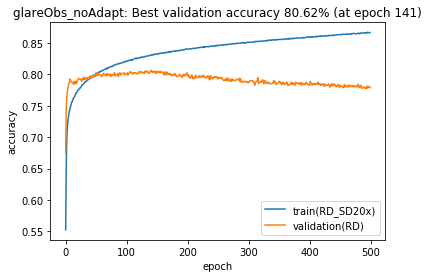

In [54]:
plt.title('glareObs_noAdapt: Best validation accuracy %s%% (at epoch %s)' \
          %(round(mean_val_accuracies.max() * 100, 2), np.argmax(mean_val_accuracies) + 1))
plt.plot(mean_accuracies)
plt.plot(mean_val_accuracies)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='lower right')
plt.show()

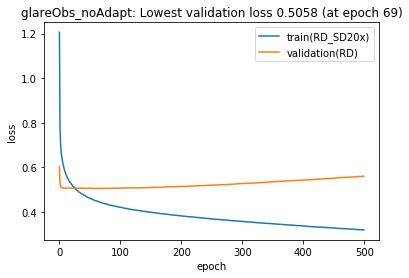

In [55]:
plt.title('glareObs_noAdapt: Lowest validation loss %s (at epoch %s)' \
          %(round(mean_val_losses.min(), 4), np.argmin(mean_val_losses) + 1))
plt.plot(mean_losses)
plt.plot(mean_val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train(RD_SD%sx)' %n_added_simulations_per_participant, 'validation(RD)'], loc='upper right')
plt.show()